# Getting Dataset form Kaggle

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

TypeError: ignored

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d aayush9753/image-colorization-dataset

In [ ]:
! unzip /content/image-colorization-dataset.zip -d dataset

## Importing Libraries

In [ ]:
import re
import os 
import urllib.request
import numpy as np
import random
import pickle
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from keras.preprocessing import image
from tqdm.notebook import tqdm as tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import keras.backend as K
import time
from copy import deepcopy
#import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from os import listdir
 
path ='/content/drive/MyDrive/Deep Learning/'
for images in os.listdir(path):
    # check if the image ends with png
    if (images.endswith(".jpg")):
        print(images)

22953.jpg
22936.jpg
22935.jpg
22963.jpg
22964.jpg
22973.jpg
22899.jpg
22974.jpg
22920.jpg
22951.jpg
22924.jpg
22942.jpg
22954.jpg
22917.jpg
22933.jpg
22969.jpg
22965.jpg
22948.jpg
22955.jpg
22911.jpg
22960.jpg
22956.jpg
22944.jpg
22925.jpg
22962.jpg
22971.jpg
22952.jpg
22915.jpg
22919.jpg
22927.jpg
22898.jpg
22950.jpg
22908.jpg
22900.jpg
22907.jpg
22966.jpg
22938.jpg
22928.jpg
22949.jpg
22912.jpg
22897.jpg
22959.jpg
22961.jpg
22934.jpg
22921.jpg
22947.jpg
22941.jpg
22958.jpg
22943.jpg
22970.jpg
23061.jpg
23014.jpg
23062.jpg
22990.jpg
23040.jpg
23049.jpg
23037.jpg
22986.jpg
23065.jpg
22991.jpg
22994.jpg
22993.jpg
23042.jpg
22983.jpg
23003.jpg
23048.jpg
23006.jpg
23001.jpg
22998.jpg
22987.jpg
23051.jpg
23009.jpg
23036.jpg
23005.jpg
23033.jpg
22989.jpg
22976.jpg
23047.jpg
23052.jpg
22980.jpg
22982.jpg
23022.jpg
23058.jpg
23060.jpg
23018.jpg
23023.jpg
23032.jpg
22978.jpg
23002.jpg
22992.jpg
23067.jpg
23026.jpg
22995.jpg
23024.jpg
23053.jpg
22977.jpg
23031.jpg
23041.jpg
23004.jpg
23012.jpg


# Read images from JPG

In [ ]:
def read_img(file, size = (256,256)):
    img = image.load_img(file, target_size=size)
    img = image.img_to_array(img)
    return img

# Image Pre processing

## Converts size of images

Converts all images to 256x256x3


In [ ]:
def convert_img_size(file_paths):
    all_images_to_array = np.zeros((len(file_paths), 256, 256, 3), dtype='int64')
    for ind, i in enumerate(file_paths):
        img = read_img(i)
        all_images_to_array[ind] = img.astype('int64')
    print('All Images shape: {} size: {:,}'.format(all_images_to_array.shape, all_images_to_array.size))
    return all_images_to_array

In [ ]:
file_paths = glob('/content/drive/MyDrive/Deep Learning/*.jpg')
X_train = convert_img_size(file_paths)

All Images shape: (3000, 256, 256, 3) size: 589,824,000


## Converting from RGB to L

In [ ]:
def rgb_to_l(img):
    img = img / 255

    l = color.rgb2lab(img)[:,:,0]
    l = l / 50 - 1
    l = l[...,np.newaxis]

    return l

## Converting from RGB to AB

In [ ]:
def rgb_to_ab(img):
    img = img / 255

    ab = color.rgb2lab(img)[:,:,1:]
    ab = (ab + 128) / 255 * 2 - 1

    return ab

## Converting from LAB to RGB

In [ ]:
def lab_to_rgb(img):
    new_img = np.zeros((256,256,3))

    for i in range(len(img)):
        for j in range(len(img[i])):
            pix = img[i,j]
            new_img[i,j] = [(pix[0] + 1) * 50,(pix[1] +1) / 2 * 255 - 128,(pix[2] +1) / 2 * 255 - 128]
    new_img = color.lab2rgb(new_img) * 255
    new_img = new_img.astype('uint8')

    return new_img

In [ ]:
L = np.array([rgb_to_l(image)for image in X_train])
AB = np.array([rgb_to_ab(image)for image in X_train])

In [ ]:
L_AB_channels = (L,AB)

In [ ]:
with open('l_ab_channels.p','wb') as f:
  pickle.dump(L_AB_channels,f, protocol=4)

## Loads in LAB channels
If you reloaded the instance you can upload the pickle files here

In [ ]:
def load_images(filepath):
  with open(filepath, 'rb') as f:
      return pickle.load(f)

In [ ]:
X_train_L, X_train_AB = load_images('l_ab_channels.p')

In [ ]:
X_test_L = deepcopy(X_train_L[:20])
X_test_AB = deepcopy(X_train_AB[:20])
X_train_L = X_train_L[20:]
X_train_AB = X_train_AB[20:]

# Create the model

In [ ]:
d_image_shape = (256,256,2)
g_image_shape = (256,256,1)

## Creating Generator

In [ ]:
def Generator():
        model = tf.keras.Sequential()
        
        model.add(tf.keras.layers.Conv2D(64,(3,3),padding='same',strides=2, input_shape=g_image_shape)) #dont need pooling since stride=2 downsizes
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU(0.2))
        
        model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same',strides=2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU(0.2))
        
        model.add(tf.keras.layers.Conv2D(256, (3,3),padding='same',strides=2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU(0.2))
        
        model.add(tf.keras.layers.Conv2D(512,(3,3),padding='same',strides=2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU(0.2))
        
        model.add(tf.keras.layers.Conv2DTranspose(256,(3,3), strides=(2,2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        
        model.add(tf.keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        
        model.add(tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        
        model.add(tf.keras.layers.Conv2DTranspose(32,(3,3),strides=(2,2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        
        model.add(tf.keras.layers.Conv2D(2,(3,3),padding='same'))
        model.add(tf.keras.layers.Activation('tanh'))
        
        l_channel = tf.keras.Input(shape=g_image_shape)
        
        image = model(l_channel)

        return tf.keras.Model(l_channel,image)

## Creating Discriminator

In [ ]:
 def Discriminator():
        model = tf.keras.Sequential()

        model.add(tf.keras.layers.Conv2D(32,(3,3), padding='same',strides=2,input_shape=d_image_shape))
        model.add(tf.keras.layers.LeakyReLU(0.2))
        model.add(tf.keras.layers.Dropout(0.25))
        
        model.add(tf.keras.layers.Conv2D(64,(3,3),padding='same',strides=2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU(.2))
        model.add(tf.keras.layers.Dropout(0.25))
        
        
        model.add(tf.keras.layers.Conv2D(128,(3,3), padding='same', strides=2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU(0.2))
        model.add(tf.keras.layers.Dropout(0.25))
        
        
        model.add(tf.keras.layers.Conv2D(256,(3,3), padding='same',strides=2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU(0.2))
        model.add(tf.keras.layers.Dropout(0.25))
        
        
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(1))
        model.add(tf.keras.layers.Activation('sigmoid'))
        
        image = tf.keras.Input(shape=d_image_shape)

        validity = model(image)
        
        return tf.keras.Model(image,validity)

## Build the Discriminator

In [ ]:
discriminator = Discriminator()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(lr=0.00008,
                                                         beta_1=0.5,
                                                         beta_2=0.999), 
                      metrics=['accuracy']) 
  
discriminator.trainable = False

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Build the Generator

In [ ]:
generator = Generator()

## Combining Networks

In [ ]:
l_channel = tf.keras.Input(shape=g_image_shape)
image = generator(l_channel) 
valid = discriminator(image)
  
combined_network = tf.keras.Model(l_channel, valid) 
combined_network.compile(loss='binary_crossentropy', 
                         optimizer=tf.keras.optimizers.Adam(lr=0.0001,
                                                            beta_1=0.5,
                                                            beta_2=0.999))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training GAN

## Lists to log the losses and accuracy

In [ ]:
gen_losses = []
disc_real_losses = []
disc_fake_losses=[] 
disc_acc = []

## Train the generator on a full set and the discriminator on a half set

In [ ]:
n = 320
y_train_fake = np.zeros([160,1])
y_train_real = np.ones([160,1])
y_gen = np.ones([n,1])

## Number of Epochs and Batch Size

In [ ]:
num_epochs=45
batch_size=32
generator.load_weights('/content/drive/MyDrive/Training/generator_45_v3.h5')

### Training stops if loss goes to 0 in discriminator

  0%|          | 0/45 [00:00<?, ?it/s]

10/10 [==============================] - 82s 8s/step - loss: 0.6578
Reached epoch: 9


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 14620 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


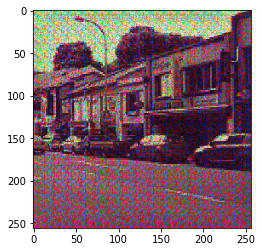

10/10 [==============================] - 83s 8s/step - loss: 0.4777
Reached epoch: 18


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 15645 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


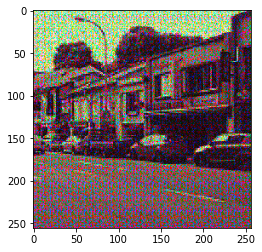

10/10 [==============================] - 81s 8s/step - loss: 0.0807
Reached epoch: 27


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 15300 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


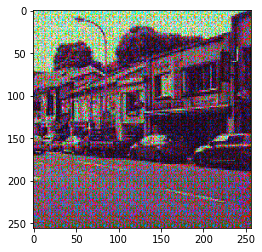

10/10 [==============================] - 81s 8s/step - loss: 0.0051
Reached epoch: 36


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 12229 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


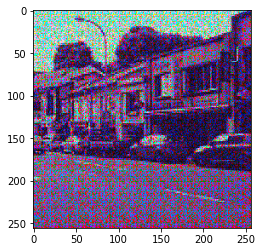

10/10 [==============================] - 81s 8s/step - loss: 9.5264e-04
Reached epoch: 45


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 11604 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


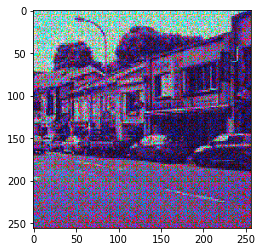

In [ ]:
for epoch in tqdm(range(1,num_epochs+1)):
  
    #shuffle L and AB channels then take a subset corresponding to each networks training size
    np.random.shuffle(X_train_L)
    l = X_train_L[:n]
    np.random.shuffle(X_train_AB)
    ab = X_train_AB[:160]
    
    fake_images = generator.predict(l[:160], verbose=1)
    
    #Train on Real AB channels and fake AB channels
    d_loss_real = discriminator.fit(x=ab, y= y_train_real,batch_size=32,epochs=1,verbose=1) 
    disc_real_losses.append(d_loss_real.history['loss'][-1])

    d_loss_fake = discriminator.fit(x=fake_images,y=y_train_fake,batch_size=32,epochs=1,verbose=1)
    disc_fake_losses.append(d_loss_fake.history['loss'][-1])
    disc_acc.append(d_loss_fake.history['accuracy'][-1])
    
    g_loss = combined_network.fit(x=l, y=y_gen,batch_size=32,epochs=1,verbose=1)
    gen_losses.append(g_loss.history['loss'][-1])

    if epoch % 9 == 0:
        print('Reached epoch:',epoch)
        pred = generator.predict(X_test_L[2].reshape(1,256,256,1))
        img = lab_to_rgb(np.dstack((X_test_L[2],pred.reshape(256,256,2))))
        plt.imshow(img)
        plt.show()
        if epoch % 9  == 0:
              generator.save('/content/drive/MyDrive/Training/generator_' + str(epoch)+ '_v3.h5')
        